[View in Colaboratory](https://colab.research.google.com/github/namlih/Bitcoin-Prediction/blob/master/LSTM_test_size_15.ipynb)

In [6]:
import pandas as pd
import numpy as np
import requests
binance  = "https://www.binance.com/api/v1/klines?symbol=BTCUSDT&interval=1d"
r = requests.get(binance)
data = r.json()

from math import log10
df = pd.DataFrame(columns=["price"])
for row in data:
    df = df.append(pd.DataFrame([float(row[1])],columns=df.columns))
df.index = [i for i in range(df.shape[0])]
df

,price
0,4261.48
1,4285.08
2,4108.37
3,4120.98
4,4069.13
5,4016.00
6,4040.00
7,4147.00
8,4316.01
9,4280.71


In [7]:
df.shape

(259, 1)

In [0]:
data_size = df.shape[0]
x_size = 7
y_size = 1

In [0]:
column_names_x = list()
for i in range(x_size):
    column_names_x.append("x"+str(i+1))
    
column_names_y = list()
for i in range(y_size):
    column_names_y.append("y"+str(i+1))
cols = ["index"]
cols += column_names_x
cols += column_names_y

In [0]:
"""Moving Window Transformation of Logged Data with window sizes: x->30 y->1"""
moving_window = pd.DataFrame(columns=cols)
for i in range(data_size-(x_size+y_size)+1):
        row = np.array([i])
        window = np.log10(df['price'].values[i:i+(x_size+y_size)])
        """Local Normalization Step"""
        window = [w-window[0] for w in window ]
        row = np.append(row,window)
        moving_window = moving_window.append(pd.DataFrame([row],columns=cols))

In [0]:
from sklearn.metrics import mean_squared_error, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Lambda
from math import sqrt
from math import log10
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from keras.callbacks import History
def build_model(x,y,input_size,output_size,epochs=1000):
    batch_size = 1
    model = Sequential()
    model.add(LSTM(128,return_sequences=True,batch_input_shape=(batch_size,input_size,1),stateful=True))
    model.add(LSTM(32,stateful=True))
    model.add(Dense(128))
    model.add(Activation('tanh'))
    model.add(Dense(64))
    model.add(Activation('tanh'))
    model.add(Dense(16))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    history = History()
    #for i in range(1000):
        #if i % 200 == 0: print(i)
    model.fit(x,y,batch_size=batch_size,epochs=epochs,shuffle=False,verbose=1,callbacks=[history])
    #model.reset_states()
    return model,history

def sMAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / ((y_true + y_pred)/2) )) * 100

def prepare_xy(train,y_size):

    x,y = train.iloc[:,:-y_size],train.iloc[:,-y_size:]
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(x.shape[0],x.shape[1],1)
    y = y.reshape(y.shape[0],y.shape[1])
    return x,y

def pred(data,model,y_size):
    
    preds = np.array([])
    for i in range(data.shape[0]):
        pred = np.array([])
        #pred = np.append(pred,data.iloc[i,0])
        #pred = np.append(pred,data.iloc[i,1])
        
        x_t = data.iloc[i,:-y_size]
        y_t = data.iloc[i,-y_size:]
        
        x_t,y_t = np.array(x_t),np.array(y_t)
        x_t = x_t.reshape(1,x_t.shape[0],1)
        
        yhat = model.predict(x_t,batch_size=1)
        yhat = yhat.reshape(yhat.shape[1],)
        for y in yhat:
            pred = np.append(pred,y)
        preds = np.append(preds,pred,axis=0)
    return preds

In [13]:
moving_window.shape

(252, 9)

In [14]:
data = moving_window.drop(['index'],axis=1)
data.head()

,x1,x2,x3,x4,x5,x6,x7,y1
0,0.0,0.002398,-0.015891,-0.014560,-0.020059,-0.025767,-0.023179,-0.011826
0,0.0,-0.018289,-0.016958,-0.022457,-0.028165,-0.025578,-0.014225,0.003124
0,0.0,0.001331,-0.004168,-0.009876,-0.007288,0.004064,0.021413,0.017846
0,0.0,-0.005499,-0.011207,-0.008619,0.002734,0.020082,0.016515,0.021739
0,0.0,-0.005708,-0.003120,0.008232,0.025581,0.022014,0.027238,0.024977


In [0]:
test_size = 15
train_size = moving_window.shape[0]-test_size
train = data[:train_size]
test = data[-test_size:]
x,y = prepare_xy(train,y_size=y_size)

In [16]:
st = time.time()
model,history = build_model(x,y,input_size=x_size,output_size=y_size,epochs=400)
ft = time.time()

Epoch 1/400
237/237 [==============================] - 3s 14ms/step - loss: 0.0056
Epoch 2/400
237/237 [==============================] - 2s 10ms/step - loss: 0.0052
Epoch 3/400
237/237 [==============================] - 2s 10ms/step - loss: 0.0047
Epoch 4/400
237/237 [==============================] - 2s 10ms/step - loss: 0.0036
Epoch 5/400
237/237 [==============================] - 2s 10ms/step - loss: 0.0019
Epoch 6/400
237/237 [==============================] - 2s 10ms/step - loss: 0.0012
Epoch 7/400
199/237 [========================>.....] - ETA: 0s - loss: 0.0011

237/237 [==============================] - 2s 10ms/step - loss: 0.0010
Epoch 8/400
237/237 [==============================] - 2s 10ms/step - loss: 9.5280e-04
Epoch 9/400
237/237 [==============================] - 2s 10ms/step - loss: 9.2120e-04
Epoch 10/400
237/237 [==============================] - 2s 10ms/step - loss: 9.0768e-04
Epoch 11/400
237/237 [==============================] - 2s 10ms/step - loss: 8.9745e-04
Epoch 12/400
237/237 [==============================] - 2s 10ms/step - loss: 8.8727e-04
Epoch 13/400
237/237 [==============================] - 2s 10ms/step - loss: 8.8045e-04
Epoch 14/400
 13/237 [>.............................] - ETA: 2s - loss: 4.1924e-04

237/237 [==============================] - 2s 9ms/step - loss: 8.9037e-04
Epoch 15/400
237/237 [==============================] - 2s 10ms/step - loss: 0.0010
Epoch 16/400
237/237 [==============================] - 2s 9ms/step - loss: 8.6628e-04
Epoch 17/400
237/237 [==============================] - 2s 10ms/step - loss: 8.5553e-04
Epoch 18/400
237/237 [==============================] - 2s 10ms/step - loss: 8.5780e-04
Epoch 19/400
237/237 [==============================] - 2s 9ms/step - loss: 8.6593e-04
Epoch 20/400
237/237 [==============================] - 2s 9ms/step - loss: 8.6427e-04
Epoch 21/400
 24/237 [==>...........................] - ETA: 2s - loss: 9.1882e-04

237/237 [==============================] - 2s 9ms/step - loss: 8.5827e-04
Epoch 22/400
237/237 [==============================] - 2s 9ms/step - loss: 9.1072e-04
Epoch 23/400
237/237 [==============================] - 2s 9ms/step - loss: 8.7414e-04
Epoch 24/400
237/237 [==============================] - 2s 9ms/step - loss: 8.4817e-04
Epoch 25/400
237/237 [==============================] - 2s 9ms/step - loss: 8.4532e-04
Epoch 26/400
237/237 [==============================] - 2s 9ms/step - loss: 8.5316e-04
Epoch 27/400
237/237 [==============================] - 2s 9ms/step - loss: 8.5328e-04
Epoch 28/400
 32/237 [===>..........................] - ETA: 1s - loss: 8.4238e-04

237/237 [==============================] - 2s 9ms/step - loss: 8.5789e-04
Epoch 29/400
237/237 [==============================] - 2s 8ms/step - loss: 8.5181e-04
Epoch 30/400
237/237 [==============================] - 2s 8ms/step - loss: 8.5849e-04
Epoch 31/400
237/237 [==============================] - 2s 9ms/step - loss: 8.5440e-04
Epoch 32/400
237/237 [==============================] - 2s 9ms/step - loss: 8.4994e-04
Epoch 33/400
237/237 [==============================] - 2s 9ms/step - loss: 8.6031e-04
Epoch 34/400
237/237 [==============================] - 2s 9ms/step - loss: 8.5907e-04
Epoch 35/400
 30/237 [==>...........................] - ETA: 1s - loss: 8.2143e-04

237/237 [==============================] - 2s 9ms/step - loss: 8.3183e-04
Epoch 36/400
237/237 [==============================] - 2s 9ms/step - loss: 8.4073e-04
Epoch 37/400
237/237 [==============================] - 2s 9ms/step - loss: 8.3653e-04
Epoch 38/400
237/237 [==============================] - 2s 9ms/step - loss: 0.0016
Epoch 39/400
237/237 [==============================] - 2s 9ms/step - loss: 0.0010
Epoch 40/400
237/237 [==============================] - 2s 9ms/step - loss: 8.4866e-04
Epoch 41/400
237/237 [==============================] - 2s 9ms/step - loss: 8.3055e-04
Epoch 42/400
 45/237 [====>.........................] - ETA: 1s - loss: 7.5009e-04

237/237 [==============================] - 2s 9ms/step - loss: 8.1691e-04
Epoch 43/400
237/237 [==============================] - 2s 9ms/step - loss: 8.0967e-04
Epoch 44/400
237/237 [==============================] - 2s 9ms/step - loss: 8.0574e-04
Epoch 45/400
237/237 [==============================] - 2s 9ms/step - loss: 8.0374e-04
Epoch 46/400
237/237 [==============================] - 2s 9ms/step - loss: 8.0346e-04
Epoch 47/400
237/237 [==============================] - 2s 9ms/step - loss: 8.0834e-04
Epoch 48/400
237/237 [==============================] - 2s 9ms/step - loss: 8.1674e-04
Epoch 49/400
 55/237 [=====>........................] - ETA: 1s - loss: 6.6957e-04

237/237 [==============================] - 2s 9ms/step - loss: 8.0666e-04
Epoch 50/400
237/237 [==============================] - 2s 9ms/step - loss: 8.0738e-04
Epoch 51/400
237/237 [==============================] - 2s 9ms/step - loss: 8.4455e-04
Epoch 52/400
237/237 [==============================] - 2s 9ms/step - loss: 7.9752e-04
Epoch 53/400
237/237 [==============================] - 2s 9ms/step - loss: 7.9099e-04
Epoch 54/400
237/237 [==============================] - 2s 9ms/step - loss: 8.0253e-04
Epoch 55/400
237/237 [==============================] - 2s 9ms/step - loss: 8.3550e-04
Epoch 56/400
 54/237 [=====>........................] - ETA: 1s - loss: 6.6292e-04

237/237 [==============================] - 2s 9ms/step - loss: 7.7387e-04
Epoch 57/400
237/237 [==============================] - 2s 8ms/step - loss: 7.7793e-04
Epoch 58/400
237/237 [==============================] - 2s 9ms/step - loss: 7.9370e-04
Epoch 59/400
237/237 [==============================] - 2s 8ms/step - loss: 8.0779e-04
Epoch 60/400
237/237 [==============================] - 2s 9ms/step - loss: 7.9169e-04
Epoch 61/400
237/237 [==============================] - 2s 9ms/step - loss: 7.8402e-04
Epoch 62/400
237/237 [==============================] - 2s 9ms/step - loss: 7.7731e-04
Epoch 63/400
 53/237 [=====>........................] - ETA: 1s - loss: 6.5467e-04

237/237 [==============================] - 2s 10ms/step - loss: 0.0014
Epoch 64/400
237/237 [==============================] - 2s 10ms/step - loss: 7.9734e-04
Epoch 65/400
237/237 [==============================] - 2s 10ms/step - loss: 7.5410e-04
Epoch 66/400
237/237 [==============================] - 2s 10ms/step - loss: 7.6570e-04
Epoch 67/400
237/237 [==============================] - 2s 10ms/step - loss: 7.7498e-04
Epoch 68/400
237/237 [==============================] - 2s 10ms/step - loss: 7.6115e-04
Epoch 69/400
237/237 [==============================] - 2s 10ms/step - loss: 8.1039e-04
Epoch 70/400
  1/237 [..............................] - ETA: 2s - loss: 3.3893e-05

237/237 [==============================] - 2s 10ms/step - loss: 7.6161e-04
Epoch 71/400
237/237 [==============================] - 2s 9ms/step - loss: 7.5791e-04
Epoch 72/400
237/237 [==============================] - 2s 9ms/step - loss: 7.5274e-04
Epoch 73/400
237/237 [==============================] - 2s 9ms/step - loss: 7.2665e-04
Epoch 74/400
237/237 [==============================] - 2s 9ms/step - loss: 7.2822e-04
Epoch 75/400
237/237 [==============================] - 2s 9ms/step - loss: 7.7627e-04
Epoch 76/400
237/237 [==============================] - 2s 9ms/step - loss: 7.2498e-04
Epoch 77/400
 25/237 [==>...........................] - ETA: 1s - loss: 8.1743e-04

237/237 [==============================] - 2s 9ms/step - loss: 7.3750e-04
Epoch 78/400
237/237 [==============================] - 2s 9ms/step - loss: 7.6422e-04
Epoch 79/400
237/237 [==============================] - 2s 9ms/step - loss: 7.2787e-04
Epoch 80/400
237/237 [==============================] - 2s 9ms/step - loss: 7.6668e-04
Epoch 81/400
237/237 [==============================] - 2s 9ms/step - loss: 7.7458e-04
Epoch 82/400
237/237 [==============================] - 2s 8ms/step - loss: 7.4828e-04
Epoch 83/400
237/237 [==============================] - 2s 9ms/step - loss: 7.4535e-04
Epoch 84/400
 77/237 [========>.....................] - ETA: 1s - loss: 5.6757e-04

237/237 [==============================] - 2s 9ms/step - loss: 7.4111e-04
Epoch 85/400
237/237 [==============================] - 2s 9ms/step - loss: 7.3163e-04
Epoch 86/400
237/237 [==============================] - 2s 8ms/step - loss: 7.2379e-04
Epoch 87/400
237/237 [==============================] - 2s 9ms/step - loss: 8.6138e-04
Epoch 88/400
237/237 [==============================] - 2s 9ms/step - loss: 7.1023e-04
Epoch 89/400
237/237 [==============================] - 2s 9ms/step - loss: 6.9945e-04
Epoch 90/400
237/237 [==============================] - 2s 9ms/step - loss: 6.8312e-04
Epoch 91/400
 79/237 [=========>....................] - ETA: 1s - loss: 5.1999e-04

237/237 [==============================] - 2s 9ms/step - loss: 7.0946e-04
Epoch 92/400
237/237 [==============================] - 2s 9ms/step - loss: 8.3113e-04
Epoch 93/400
237/237 [==============================] - 2s 9ms/step - loss: 7.1996e-04
Epoch 94/400
237/237 [==============================] - 2s 9ms/step - loss: 6.8776e-04
Epoch 95/400
237/237 [==============================] - 2s 9ms/step - loss: 8.9501e-04
Epoch 96/400
237/237 [==============================] - 2s 8ms/step - loss: 7.6131e-04
Epoch 97/400
237/237 [==============================] - 2s 8ms/step - loss: 7.3691e-04
Epoch 98/400
 92/237 [==========>...................] - ETA: 1s - loss: 5.2791e-04

237/237 [==============================] - 2s 9ms/step - loss: 7.2689e-04
Epoch 99/400
237/237 [==============================] - 2s 9ms/step - loss: 7.2064e-04
Epoch 100/400
237/237 [==============================] - 2s 9ms/step - loss: 7.1037e-04
Epoch 101/400
237/237 [==============================] - 2s 9ms/step - loss: 7.0181e-04
Epoch 102/400
237/237 [==============================] - 2s 9ms/step - loss: 6.8856e-04
Epoch 103/400
237/237 [==============================] - 2s 9ms/step - loss: 6.7397e-04
Epoch 104/400
237/237 [==============================] - 2s 9ms/step - loss: 6.6532e-04
Epoch 105/400
 62/237 [======>.......................] - ETA: 1s - loss: 5.5271e-04

237/237 [==============================] - 2s 8ms/step - loss: 6.5856e-04
Epoch 106/400
237/237 [==============================] - 2s 8ms/step - loss: 7.4330e-04
Epoch 107/400
237/237 [==============================] - 2s 8ms/step - loss: 7.0866e-04
Epoch 108/400
237/237 [==============================] - 2s 8ms/step - loss: 7.0925e-04
Epoch 109/400
237/237 [==============================] - 2s 8ms/step - loss: 6.7311e-04
Epoch 110/400
237/237 [==============================] - 2s 8ms/step - loss: 6.6280e-04
Epoch 111/400
237/237 [==============================] - 2s 8ms/step - loss: 6.5158e-04
Epoch 112/400
131/237 [===============>..............] - ETA: 0s - loss: 6.1313e-04

237/237 [==============================] - 2s 8ms/step - loss: 6.5040e-04
Epoch 113/400
237/237 [==============================] - 2s 8ms/step - loss: 6.4412e-04
Epoch 114/400
237/237 [==============================] - 2s 8ms/step - loss: 6.4575e-04
Epoch 115/400
237/237 [==============================] - 2s 8ms/step - loss: 6.5206e-04
Epoch 116/400
237/237 [==============================] - 2s 8ms/step - loss: 6.2773e-04
Epoch 117/400
237/237 [==============================] - 2s 8ms/step - loss: 0.0013
Epoch 118/400
237/237 [==============================] - 2s 9ms/step - loss: 8.3693e-04
Epoch 119/400
114/237 [=============>................] - ETA: 1s - loss: 5.8095e-04

237/237 [==============================] - 2s 8ms/step - loss: 7.5624e-04
Epoch 120/400
237/237 [==============================] - 2s 9ms/step - loss: 7.2873e-04
Epoch 121/400
237/237 [==============================] - 2s 9ms/step - loss: 7.1489e-04
Epoch 122/400
237/237 [==============================] - 2s 8ms/step - loss: 7.0738e-04
Epoch 123/400
237/237 [==============================] - 2s 9ms/step - loss: 7.0384e-04
Epoch 124/400
237/237 [==============================] - 2s 8ms/step - loss: 6.9738e-04
Epoch 125/400
237/237 [==============================] - 2s 8ms/step - loss: 6.9622e-04
Epoch 126/400
 95/237 [===========>..................] - ETA: 1s - loss: 4.9814e-04

237/237 [==============================] - 2s 8ms/step - loss: 6.9593e-04
Epoch 127/400
237/237 [==============================] - 2s 8ms/step - loss: 6.9338e-04
Epoch 128/400
237/237 [==============================] - 2s 8ms/step - loss: 6.8349e-04
Epoch 129/400
237/237 [==============================] - 2s 8ms/step - loss: 6.7802e-04
Epoch 130/400
237/237 [==============================] - 2s 8ms/step - loss: 6.6745e-04
Epoch 131/400
237/237 [==============================] - 2s 8ms/step - loss: 6.6043e-04
Epoch 132/400
237/237 [==============================] - 2s 8ms/step - loss: 6.6154e-04
Epoch 133/400
125/237 [==============>...............] - ETA: 0s - loss: 5.9350e-04

237/237 [==============================] - 2s 8ms/step - loss: 6.5897e-04
Epoch 134/400
237/237 [==============================] - 2s 8ms/step - loss: 6.4412e-04
Epoch 135/400
237/237 [==============================] - 2s 8ms/step - loss: 6.5296e-04
Epoch 136/400
237/237 [==============================] - 2s 8ms/step - loss: 6.4657e-04
Epoch 137/400
237/237 [==============================] - 2s 9ms/step - loss: 6.5452e-04
Epoch 138/400
237/237 [==============================] - 2s 8ms/step - loss: 6.4590e-04
Epoch 139/400
237/237 [==============================] - 2s 8ms/step - loss: 6.2235e-04
Epoch 140/400
117/237 [=============>................] - ETA: 0s - loss: 5.6720e-04

237/237 [==============================] - 2s 8ms/step - loss: 7.7800e-04
Epoch 141/400
237/237 [==============================] - 2s 8ms/step - loss: 6.6938e-04
Epoch 142/400
237/237 [==============================] - 2s 8ms/step - loss: 6.2344e-04
Epoch 143/400
237/237 [==============================] - 2s 8ms/step - loss: 5.9223e-04
Epoch 144/400
237/237 [==============================] - 2s 8ms/step - loss: 5.9352e-04
Epoch 145/400
237/237 [==============================] - 2s 8ms/step - loss: 6.3880e-04
Epoch 146/400
237/237 [==============================] - 2s 8ms/step - loss: 6.3051e-04
Epoch 147/400
116/237 [=============>................] - ETA: 1s - loss: 4.7822e-04

237/237 [==============================] - 2s 9ms/step - loss: 5.9894e-04
Epoch 148/400
237/237 [==============================] - 2s 8ms/step - loss: 6.0452e-04
Epoch 149/400
237/237 [==============================] - 2s 8ms/step - loss: 6.0523e-04
Epoch 150/400
237/237 [==============================] - 2s 9ms/step - loss: 6.0801e-04
Epoch 151/400
237/237 [==============================] - 2s 8ms/step - loss: 6.1007e-04
Epoch 152/400
237/237 [==============================] - 2s 8ms/step - loss: 5.8454e-04
Epoch 153/400
237/237 [==============================] - 2s 9ms/step - loss: 6.5339e-04
Epoch 154/400
102/237 [===========>..................] - ETA: 1s - loss: 4.5562e-04

237/237 [==============================] - 2s 9ms/step - loss: 5.8312e-04
Epoch 155/400
237/237 [==============================] - 2s 8ms/step - loss: 6.5642e-04
Epoch 156/400
237/237 [==============================] - 2s 8ms/step - loss: 7.3576e-04
Epoch 157/400
237/237 [==============================] - 2s 8ms/step - loss: 6.7537e-04
Epoch 158/400
237/237 [==============================] - 2s 8ms/step - loss: 5.6782e-04
Epoch 159/400
237/237 [==============================] - 2s 9ms/step - loss: 5.9482e-04
Epoch 160/400
237/237 [==============================] - 2s 9ms/step - loss: 5.5848e-04
Epoch 161/400
 89/237 [==========>...................] - ETA: 1s - loss: 5.1904e-04

237/237 [==============================] - 2s 9ms/step - loss: 5.5905e-04
Epoch 162/400
237/237 [==============================] - 2s 8ms/step - loss: 6.1061e-04
Epoch 163/400
237/237 [==============================] - 2s 9ms/step - loss: 5.8488e-04
Epoch 164/400
237/237 [==============================] - 2s 8ms/step - loss: 6.6100e-04
Epoch 165/400
237/237 [==============================] - 2s 8ms/step - loss: 5.3543e-04
Epoch 166/400
237/237 [==============================] - 2s 8ms/step - loss: 5.3016e-04
Epoch 167/400
237/237 [==============================] - 2s 8ms/step - loss: 5.2247e-04
Epoch 168/400
118/237 [=============>................] - ETA: 1s - loss: 4.8123e-04

237/237 [==============================] - 2s 8ms/step - loss: 4.7899e-04
Epoch 169/400
237/237 [==============================] - 2s 8ms/step - loss: 5.2402e-04
Epoch 170/400
237/237 [==============================] - 2s 8ms/step - loss: 5.5025e-04
Epoch 171/400
237/237 [==============================] - 2s 8ms/step - loss: 6.1024e-04
Epoch 172/400
237/237 [==============================] - 2s 8ms/step - loss: 5.8953e-04
Epoch 173/400
237/237 [==============================] - 2s 8ms/step - loss: 5.4375e-04
Epoch 174/400
237/237 [==============================] - 2s 8ms/step - loss: 5.0932e-04
Epoch 175/400
112/237 [=============>................] - ETA: 1s - loss: 4.8716e-04

237/237 [==============================] - 2s 8ms/step - loss: 4.9385e-04
Epoch 176/400
237/237 [==============================] - 2s 8ms/step - loss: 7.0377e-04
Epoch 177/400
237/237 [==============================] - 2s 9ms/step - loss: 7.8128e-04
Epoch 178/400
237/237 [==============================] - 2s 8ms/step - loss: 5.6813e-04
Epoch 179/400
237/237 [==============================] - 2s 9ms/step - loss: 4.9497e-04
Epoch 180/400
237/237 [==============================] - 2s 8ms/step - loss: 4.6199e-04
Epoch 181/400
237/237 [==============================] - 2s 9ms/step - loss: 6.4686e-04
Epoch 182/400
 89/237 [==========>...................] - ETA: 1s - loss: 4.7481e-04

237/237 [==============================] - 2s 9ms/step - loss: 5.8462e-04
Epoch 183/400
237/237 [==============================] - 2s 9ms/step - loss: 5.5297e-04
Epoch 184/400
237/237 [==============================] - 2s 8ms/step - loss: 4.7760e-04
Epoch 185/400
237/237 [==============================] - 2s 8ms/step - loss: 4.7993e-04
Epoch 186/400
237/237 [==============================] - 2s 8ms/step - loss: 4.3633e-04
Epoch 187/400
237/237 [==============================] - 2s 8ms/step - loss: 5.0993e-04
Epoch 188/400
237/237 [==============================] - 2s 8ms/step - loss: 5.3061e-04
Epoch 189/400
103/237 [============>.................] - ETA: 1s - loss: 4.1595e-04

237/237 [==============================] - 2s 8ms/step - loss: 4.5431e-04
Epoch 190/400
237/237 [==============================] - 2s 8ms/step - loss: 4.6919e-04
Epoch 191/400
237/237 [==============================] - 2s 8ms/step - loss: 5.2991e-04
Epoch 192/400
237/237 [==============================] - 2s 8ms/step - loss: 5.3739e-04
Epoch 193/400
237/237 [==============================] - 2s 9ms/step - loss: 5.9752e-04
Epoch 194/400
237/237 [==============================] - 2s 8ms/step - loss: 4.7699e-04
Epoch 195/400
237/237 [==============================] - 2s 9ms/step - loss: 4.7713e-04
Epoch 196/400
 90/237 [==========>...................] - ETA: 1s - loss: 3.3067e-04

237/237 [==============================] - 2s 9ms/step - loss: 3.8582e-04
Epoch 197/400
237/237 [==============================] - 2s 9ms/step - loss: 5.0153e-04
Epoch 198/400
237/237 [==============================] - 2s 9ms/step - loss: 4.0226e-04
Epoch 199/400
237/237 [==============================] - 2s 9ms/step - loss: 8.4873e-04
Epoch 200/400
237/237 [==============================] - 2s 9ms/step - loss: 7.5789e-04
Epoch 201/400
237/237 [==============================] - 2s 8ms/step - loss: 4.7613e-04
Epoch 202/400
237/237 [==============================] - 2s 8ms/step - loss: 4.2414e-04
Epoch 203/400
 96/237 [===========>..................] - ETA: 1s - loss: 3.6341e-04

237/237 [==============================] - 2s 8ms/step - loss: 3.8601e-04
Epoch 204/400
237/237 [==============================] - 2s 8ms/step - loss: 4.2191e-04
Epoch 205/400
237/237 [==============================] - 2s 8ms/step - loss: 4.4844e-04
Epoch 206/400
237/237 [==============================] - 2s 8ms/step - loss: 5.0831e-04
Epoch 207/400
237/237 [==============================] - 2s 9ms/step - loss: 5.2433e-04
Epoch 208/400
237/237 [==============================] - 2s 8ms/step - loss: 4.9831e-04
Epoch 209/400
237/237 [==============================] - 2s 9ms/step - loss: 4.0987e-04
Epoch 210/400
 74/237 [========>.....................] - ETA: 1s - loss: 2.9571e-04

237/237 [==============================] - 2s 9ms/step - loss: 5.9131e-04
Epoch 211/400
237/237 [==============================] - 2s 9ms/step - loss: 4.6752e-04
Epoch 212/400
237/237 [==============================] - 2s 9ms/step - loss: 4.5735e-04
Epoch 213/400
237/237 [==============================] - 2s 9ms/step - loss: 4.2916e-04
Epoch 214/400
237/237 [==============================] - 2s 9ms/step - loss: 4.2032e-04
Epoch 215/400
237/237 [==============================] - 2s 8ms/step - loss: 5.5782e-04
Epoch 216/400
237/237 [==============================] - 2s 9ms/step - loss: 5.1782e-04
Epoch 217/400
 69/237 [=======>......................] - ETA: 1s - loss: 4.0028e-04

237/237 [==============================] - 2s 8ms/step - loss: 4.6936e-04
Epoch 218/400
237/237 [==============================] - 2s 9ms/step - loss: 4.0839e-04
Epoch 219/400
237/237 [==============================] - 2s 9ms/step - loss: 4.1142e-04
Epoch 220/400
237/237 [==============================] - 2s 8ms/step - loss: 0.0010
Epoch 221/400
237/237 [==============================] - 2s 9ms/step - loss: 5.9508e-04
Epoch 222/400
237/237 [==============================] - 2s 8ms/step - loss: 5.1991e-04
Epoch 223/400
237/237 [==============================] - 2s 8ms/step - loss: 4.4106e-04
Epoch 224/400
100/237 [===========>..................] - ETA: 1s - loss: 3.4834e-04

237/237 [==============================] - 2s 8ms/step - loss: 5.1725e-04
Epoch 225/400
237/237 [==============================] - 2s 9ms/step - loss: 4.1087e-04
Epoch 226/400
237/237 [==============================] - 2s 8ms/step - loss: 3.8542e-04
Epoch 227/400
237/237 [==============================] - 2s 9ms/step - loss: 4.2597e-04
Epoch 228/400
237/237 [==============================] - 2s 8ms/step - loss: 3.9191e-04
Epoch 229/400
237/237 [==============================] - 2s 8ms/step - loss: 4.5219e-04
Epoch 230/400
237/237 [==============================] - 2s 9ms/step - loss: 4.6941e-04
Epoch 231/400
100/237 [===========>..................] - ETA: 1s - loss: 3.8747e-04

237/237 [==============================] - 2s 8ms/step - loss: 4.3678e-04
Epoch 232/400
237/237 [==============================] - 2s 8ms/step - loss: 4.0027e-04
Epoch 233/400
237/237 [==============================] - 2s 8ms/step - loss: 3.7450e-04
Epoch 234/400
237/237 [==============================] - 2s 8ms/step - loss: 5.7014e-04
Epoch 235/400
237/237 [==============================] - 2s 9ms/step - loss: 4.0574e-04
Epoch 236/400
237/237 [==============================] - 2s 8ms/step - loss: 3.8150e-04
Epoch 237/400
237/237 [==============================] - 2s 9ms/step - loss: 3.5117e-04
Epoch 238/400
 88/237 [==========>...................] - ETA: 1s - loss: 3.2068e-04

237/237 [==============================] - 2s 9ms/step - loss: 3.8078e-04
Epoch 239/400
237/237 [==============================] - 2s 9ms/step - loss: 4.6647e-04
Epoch 240/400
237/237 [==============================] - 2s 9ms/step - loss: 3.2534e-04
Epoch 241/400
237/237 [==============================] - 2s 9ms/step - loss: 3.5751e-04
Epoch 242/400
237/237 [==============================] - 2s 9ms/step - loss: 4.5733e-04
Epoch 243/400
237/237 [==============================] - 2s 9ms/step - loss: 5.0478e-04
Epoch 244/400
237/237 [==============================] - 2s 9ms/step - loss: 3.8098e-04
Epoch 245/400
 65/237 [=======>......................] - ETA: 1s - loss: 3.4635e-04

237/237 [==============================] - 2s 8ms/step - loss: 3.4964e-04
Epoch 246/400
237/237 [==============================] - 2s 9ms/step - loss: 3.0239e-04
Epoch 247/400
237/237 [==============================] - 2s 9ms/step - loss: 3.9654e-04
Epoch 248/400
237/237 [==============================] - 2s 9ms/step - loss: 3.6168e-04
Epoch 249/400
237/237 [==============================] - 2s 8ms/step - loss: 3.1287e-04
Epoch 250/400
237/237 [==============================] - 2s 9ms/step - loss: 3.5012e-04
Epoch 251/400
237/237 [==============================] - 2s 9ms/step - loss: 3.2202e-04
Epoch 252/400
 78/237 [========>.....................] - ETA: 1s - loss: 2.6607e-04

237/237 [==============================] - 2s 9ms/step - loss: 3.0881e-04
Epoch 253/400
237/237 [==============================] - 2s 9ms/step - loss: 3.3215e-04
Epoch 254/400
237/237 [==============================] - 2s 9ms/step - loss: 3.5624e-04
Epoch 255/400
237/237 [==============================] - 2s 9ms/step - loss: 4.7843e-04
Epoch 256/400
237/237 [==============================] - 2s 9ms/step - loss: 3.4094e-04
Epoch 257/400
237/237 [==============================] - 2s 9ms/step - loss: 3.1696e-04
Epoch 258/400
237/237 [==============================] - 2s 9ms/step - loss: 4.7468e-04
Epoch 259/400
 77/237 [========>.....................] - ETA: 1s - loss: 3.9556e-04

237/237 [==============================] - 2s 9ms/step - loss: 3.7745e-04
Epoch 260/400
237/237 [==============================] - 2s 8ms/step - loss: 2.6966e-04
Epoch 261/400
237/237 [==============================] - 2s 9ms/step - loss: 2.4797e-04
Epoch 262/400
237/237 [==============================] - 2s 9ms/step - loss: 3.5053e-04
Epoch 263/400
237/237 [==============================] - 2s 9ms/step - loss: 3.7789e-04
Epoch 264/400
237/237 [==============================] - 2s 9ms/step - loss: 4.0075e-04
Epoch 265/400
237/237 [==============================] - 2s 9ms/step - loss: 3.3054e-04
Epoch 266/400
 63/237 [======>.......................] - ETA: 1s - loss: 2.1937e-04

237/237 [==============================] - 2s 9ms/step - loss: 4.4553e-04
Epoch 267/400
237/237 [==============================] - 2s 9ms/step - loss: 3.4297e-04
Epoch 268/400
237/237 [==============================] - 2s 9ms/step - loss: 2.9604e-04
Epoch 269/400
237/237 [==============================] - 2s 9ms/step - loss: 2.6281e-04
Epoch 270/400
237/237 [==============================] - 2s 9ms/step - loss: 2.7474e-04
Epoch 271/400
237/237 [==============================] - 2s 9ms/step - loss: 3.3192e-04
Epoch 272/400
237/237 [==============================] - 2s 9ms/step - loss: 3.4692e-04
Epoch 273/400
 48/237 [=====>........................] - ETA: 1s - loss: 3.5715e-04

237/237 [==============================] - 2s 9ms/step - loss: 3.5215e-04
Epoch 274/400
237/237 [==============================] - 2s 9ms/step - loss: 2.7177e-04
Epoch 275/400
237/237 [==============================] - 2s 9ms/step - loss: 2.5669e-04
Epoch 276/400
237/237 [==============================] - 2s 8ms/step - loss: 3.1650e-04
Epoch 277/400
237/237 [==============================] - 2s 9ms/step - loss: 4.4485e-04
Epoch 278/400
237/237 [==============================] - 2s 8ms/step - loss: 3.0973e-04
Epoch 279/400
237/237 [==============================] - 2s 8ms/step - loss: 2.6373e-04
Epoch 280/400
 76/237 [========>.....................] - ETA: 1s - loss: 2.2701e-04

237/237 [==============================] - 2s 9ms/step - loss: 2.3923e-04
Epoch 281/400
237/237 [==============================] - 2s 9ms/step - loss: 3.5734e-04
Epoch 282/400
237/237 [==============================] - 2s 9ms/step - loss: 2.9439e-04
Epoch 283/400
237/237 [==============================] - 2s 9ms/step - loss: 2.5391e-04
Epoch 284/400
237/237 [==============================] - 2s 9ms/step - loss: 3.1015e-04
Epoch 285/400
237/237 [==============================] - 2s 9ms/step - loss: 3.9252e-04
Epoch 286/400
237/237 [==============================] - 2s 9ms/step - loss: 3.2006e-04
Epoch 287/400
 39/237 [===>..........................] - ETA: 1s - loss: 2.7803e-04

237/237 [==============================] - 2s 9ms/step - loss: 3.6887e-04
Epoch 288/400
237/237 [==============================] - 2s 8ms/step - loss: 4.9239e-04
Epoch 289/400
237/237 [==============================] - 2s 8ms/step - loss: 5.1882e-04
Epoch 290/400
237/237 [==============================] - 2s 8ms/step - loss: 3.3700e-04
Epoch 291/400
237/237 [==============================] - 2s 8ms/step - loss: 3.3530e-04
Epoch 292/400
237/237 [==============================] - 2s 8ms/step - loss: 2.2012e-04
Epoch 293/400
237/237 [==============================] - 2s 8ms/step - loss: 2.2508e-04
Epoch 294/400
104/237 [============>.................] - ETA: 1s - loss: 2.2797e-04

237/237 [==============================] - 2s 8ms/step - loss: 2.7726e-04
Epoch 295/400
237/237 [==============================] - 2s 9ms/step - loss: 2.3755e-04
Epoch 296/400
237/237 [==============================] - 2s 9ms/step - loss: 2.3058e-04
Epoch 297/400
237/237 [==============================] - 2s 9ms/step - loss: 2.9501e-04
Epoch 298/400
237/237 [==============================] - 2s 9ms/step - loss: 3.5700e-04
Epoch 299/400
237/237 [==============================] - 2s 9ms/step - loss: 2.8729e-04
Epoch 300/400
237/237 [==============================] - 2s 9ms/step - loss: 2.8884e-04
Epoch 301/400
 49/237 [=====>........................] - ETA: 1s - loss: 2.2827e-04

237/237 [==============================] - 2s 9ms/step - loss: 2.9094e-04
Epoch 302/400
237/237 [==============================] - 2s 9ms/step - loss: 4.4904e-04
Epoch 303/400
237/237 [==============================] - 2s 9ms/step - loss: 2.9215e-04
Epoch 304/400
237/237 [==============================] - 2s 9ms/step - loss: 3.3125e-04
Epoch 305/400
237/237 [==============================] - 2s 9ms/step - loss: 2.5873e-04
Epoch 306/400
237/237 [==============================] - 2s 9ms/step - loss: 2.5959e-04
Epoch 307/400
237/237 [==============================] - 2s 9ms/step - loss: 4.2029e-04
Epoch 308/400
 55/237 [=====>........................] - ETA: 1s - loss: 4.9225e-04

237/237 [==============================] - 2s 9ms/step - loss: 4.2808e-04
Epoch 309/400
237/237 [==============================] - 2s 9ms/step - loss: 3.4487e-04
Epoch 310/400
237/237 [==============================] - 2s 9ms/step - loss: 3.1193e-04
Epoch 311/400
237/237 [==============================] - 2s 9ms/step - loss: 2.3449e-04
Epoch 312/400
237/237 [==============================] - 2s 8ms/step - loss: 2.2882e-04
Epoch 313/400
237/237 [==============================] - 2s 8ms/step - loss: 2.5120e-04
Epoch 314/400
237/237 [==============================] - 2s 8ms/step - loss: 1.9976e-04
Epoch 315/400
 70/237 [=======>......................] - ETA: 1s - loss: 2.4347e-04

237/237 [==============================] - 2s 9ms/step - loss: 2.4851e-04
Epoch 316/400
237/237 [==============================] - 2s 9ms/step - loss: 1.8359e-04
Epoch 317/400
237/237 [==============================] - 2s 9ms/step - loss: 2.2460e-04
Epoch 318/400
237/237 [==============================] - 2s 9ms/step - loss: 2.7623e-04
Epoch 319/400
237/237 [==============================] - 2s 8ms/step - loss: 2.8949e-04
Epoch 320/400
237/237 [==============================] - 2s 9ms/step - loss: 1.7271e-04
Epoch 321/400
237/237 [==============================] - 2s 9ms/step - loss: 2.2214e-04
Epoch 322/400
 68/237 [=======>......................] - ETA: 1s - loss: 1.6567e-04

237/237 [==============================] - 2s 9ms/step - loss: 1.7237e-04
Epoch 323/400
237/237 [==============================] - 2s 9ms/step - loss: 2.4881e-04
Epoch 324/400
237/237 [==============================] - 2s 9ms/step - loss: 2.1769e-04
Epoch 325/400
237/237 [==============================] - 2s 9ms/step - loss: 2.8328e-04
Epoch 326/400
237/237 [==============================] - 2s 9ms/step - loss: 1.6567e-04
Epoch 327/400
237/237 [==============================] - 2s 9ms/step - loss: 2.5284e-04
Epoch 328/400
237/237 [==============================] - 2s 9ms/step - loss: 3.0359e-04
Epoch 329/400
 43/237 [====>.........................] - ETA: 1s - loss: 3.7409e-04

237/237 [==============================] - 2s 9ms/step - loss: 2.4702e-04
Epoch 330/400
237/237 [==============================] - 2s 9ms/step - loss: 2.4356e-04
Epoch 331/400
237/237 [==============================] - 2s 8ms/step - loss: 1.8579e-04
Epoch 332/400
237/237 [==============================] - 2s 8ms/step - loss: 2.1277e-04
Epoch 333/400
237/237 [==============================] - 2s 8ms/step - loss: 1.8636e-04
Epoch 334/400
237/237 [==============================] - 2s 8ms/step - loss: 1.9192e-04
Epoch 335/400
237/237 [==============================] - 2s 8ms/step - loss: 2.6992e-04
Epoch 336/400
108/237 [============>.................] - ETA: 1s - loss: 2.5347e-04

237/237 [==============================] - 2s 8ms/step - loss: 3.0020e-04
Epoch 337/400
237/237 [==============================] - 2s 8ms/step - loss: 2.6035e-04
Epoch 338/400
237/237 [==============================] - 2s 8ms/step - loss: 2.1538e-04
Epoch 339/400
237/237 [==============================] - 2s 8ms/step - loss: 2.6926e-04
Epoch 340/400
237/237 [==============================] - 2s 8ms/step - loss: 3.3273e-04
Epoch 341/400
237/237 [==============================] - 2s 8ms/step - loss: 2.3229e-04
Epoch 342/400
237/237 [==============================] - 2s 8ms/step - loss: 2.2363e-04
Epoch 343/400
134/237 [===============>..............] - ETA: 0s - loss: 1.4668e-04

237/237 [==============================] - 2s 8ms/step - loss: 1.7549e-04
Epoch 344/400
237/237 [==============================] - 2s 8ms/step - loss: 1.6661e-04
Epoch 345/400
237/237 [==============================] - 2s 9ms/step - loss: 1.7685e-04
Epoch 346/400
237/237 [==============================] - 2s 8ms/step - loss: 2.1033e-04
Epoch 347/400
237/237 [==============================] - 2s 8ms/step - loss: 1.9188e-04
Epoch 348/400
237/237 [==============================] - 2s 8ms/step - loss: 2.2860e-04
Epoch 349/400
237/237 [==============================] - 2s 8ms/step - loss: 3.5437e-04
Epoch 350/400
132/237 [===============>..............] - ETA: 0s - loss: 2.2148e-04

237/237 [==============================] - 2s 8ms/step - loss: 2.5424e-04
Epoch 351/400
237/237 [==============================] - 2s 8ms/step - loss: 3.0837e-04
Epoch 352/400
237/237 [==============================] - 2s 9ms/step - loss: 3.2893e-04
Epoch 353/400
237/237 [==============================] - 2s 8ms/step - loss: 1.8934e-04
Epoch 354/400
237/237 [==============================] - 2s 9ms/step - loss: 1.9660e-04
Epoch 355/400
237/237 [==============================] - 2s 9ms/step - loss: 1.9124e-04
Epoch 356/400
237/237 [==============================] - 2s 9ms/step - loss: 1.6273e-04
Epoch 357/400
 56/237 [======>.......................] - ETA: 1s - loss: 1.5692e-04

237/237 [==============================] - 2s 9ms/step - loss: 1.2500e-04
Epoch 358/400
237/237 [==============================] - 2s 9ms/step - loss: 1.5785e-04
Epoch 359/400
237/237 [==============================] - 2s 8ms/step - loss: 2.3124e-04
Epoch 360/400
237/237 [==============================] - 2s 8ms/step - loss: 3.1062e-04
Epoch 361/400
237/237 [==============================] - 2s 9ms/step - loss: 2.8576e-04
Epoch 362/400
237/237 [==============================] - 2s 9ms/step - loss: 1.9282e-04
Epoch 363/400
237/237 [==============================] - 2s 8ms/step - loss: 2.1930e-04
Epoch 364/400
 87/237 [==========>...................] - ETA: 1s - loss: 1.6189e-04

237/237 [==============================] - 2s 8ms/step - loss: 1.6241e-04
Epoch 365/400
237/237 [==============================] - 2s 8ms/step - loss: 1.6829e-04
Epoch 366/400
237/237 [==============================] - 2s 9ms/step - loss: 1.5217e-04
Epoch 367/400
237/237 [==============================] - 2s 8ms/step - loss: 1.5314e-04
Epoch 368/400
237/237 [==============================] - 2s 9ms/step - loss: 1.8962e-04
Epoch 369/400
237/237 [==============================] - 2s 9ms/step - loss: 2.0767e-04
Epoch 370/400
237/237 [==============================] - 2s 9ms/step - loss: 1.6009e-04
Epoch 371/400
 42/237 [====>.........................] - ETA: 1s - loss: 9.9970e-05

237/237 [==============================] - 2s 9ms/step - loss: 1.2917e-04
Epoch 372/400
237/237 [==============================] - 2s 9ms/step - loss: 1.5127e-04
Epoch 373/400
237/237 [==============================] - 2s 9ms/step - loss: 2.4158e-04
Epoch 374/400
237/237 [==============================] - 2s 9ms/step - loss: 2.3947e-04
Epoch 375/400
237/237 [==============================] - 2s 9ms/step - loss: 3.6763e-04
Epoch 376/400
237/237 [==============================] - 2s 8ms/step - loss: 2.0016e-04
Epoch 377/400
237/237 [==============================] - 2s 8ms/step - loss: 1.5829e-04
Epoch 378/400
 61/237 [======>.......................] - ETA: 1s - loss: 1.4141e-04

237/237 [==============================] - 2s 8ms/step - loss: 1.3241e-04
Epoch 379/400
237/237 [==============================] - 2s 9ms/step - loss: 1.4938e-04
Epoch 380/400
237/237 [==============================] - 2s 9ms/step - loss: 2.3844e-04
Epoch 381/400
237/237 [==============================] - 2s 8ms/step - loss: 1.9470e-04
Epoch 382/400
237/237 [==============================] - 2s 8ms/step - loss: 3.2700e-04
Epoch 383/400
237/237 [==============================] - 2s 9ms/step - loss: 2.9961e-04
Epoch 384/400
237/237 [==============================] - 2s 9ms/step - loss: 1.6020e-04
Epoch 385/400
 73/237 [========>.....................] - ETA: 1s - loss: 8.1492e-05

237/237 [==============================] - 2s 9ms/step - loss: 9.4590e-05
Epoch 386/400
237/237 [==============================] - 2s 9ms/step - loss: 1.0461e-04
Epoch 387/400
237/237 [==============================] - 2s 9ms/step - loss: 7.0708e-05
Epoch 388/400
237/237 [==============================] - 2s 9ms/step - loss: 1.0268e-04
Epoch 389/400
237/237 [==============================] - 2s 8ms/step - loss: 2.0899e-04
Epoch 390/400
237/237 [==============================] - 2s 9ms/step - loss: 3.4186e-04
Epoch 391/400
237/237 [==============================] - 2s 8ms/step - loss: 3.3124e-04
Epoch 392/400
 85/237 [=========>....................] - ETA: 1s - loss: 2.8735e-04

237/237 [==============================] - 2s 8ms/step - loss: 2.6817e-04
Epoch 393/400
237/237 [==============================] - 2s 8ms/step - loss: 1.4460e-04
Epoch 394/400
237/237 [==============================] - 2s 8ms/step - loss: 1.1237e-04
Epoch 395/400
237/237 [==============================] - 2s 8ms/step - loss: 9.7305e-05
Epoch 396/400
237/237 [==============================] - 2s 8ms/step - loss: 9.6354e-05
Epoch 397/400
237/237 [==============================] - 2s 8ms/step - loss: 1.1523e-04
Epoch 398/400
237/237 [==============================] - 2s 8ms/step - loss: 1.2634e-04
Epoch 399/400
125/237 [==============>...............] - ETA: 0s - loss: 1.1441e-04

237/237 [==============================] - 2s 8ms/step - loss: 1.2353e-04
Epoch 400/400
237/237 [==============================] - 2s 8ms/step - loss: 1.5158e-04


In [0]:
preds = pred(test,model,y_size=1)
"""Renormalization and Get Rid of Log"""
for i,p in enumerate(preds):
    preds[i] = 10**(p+np.log10(df['price'].values[-30+i]))

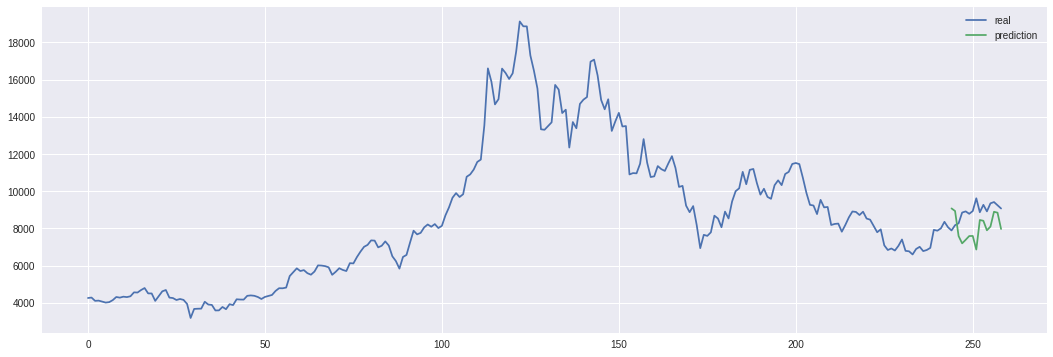

In [18]:
plt.figure(figsize=(18,6))
plt.plot(pd.Series(df['price'].values,index=range(df.shape[0])),label="real")
plt.plot(pd.Series(preds,index=range(df.shape[0]-test_size,df.shape[0])),label="prediction")
plt.legend()
plt.show()

In [19]:
sMAPE(df['price'].values[-test_size:],preds)

13.26955877435453

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(df['price'][-test_size:], preds))
rms

1250.9371074599915

In [21]:
ft-st

825.1369490623474